# Library

In [1]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import math

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe, fe, scoring, deep_learning, visual

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [5]:
# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Parameter

In [4]:
# training parameters
batch_size = 32
epochs = 200
data_augmentation = True

In [5]:
# network parameters
num_classes = 10
num_dense_blocks = 3
use_max_pool = False

In [6]:
# DenseNet-BC with dataset augmentation
# Growth rate   | Depth |  Accuracy (paper)| Accuracy (this)      |
# 12            | 100   |  95.49%          | 93.74%               |
# 24            | 250   |  96.38%          | requires big mem GPU |
# 40            | 190   |  96.54%          | requires big mem GPU |

# Label

In [7]:
# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Model

In [13]:
x_train,x_test,model_type,callback,model = deep_learning.densenet_model(
    x_train,x_test,
    num_classes=10,
    growth_rate = 12,
    depth = 100,
    num_dense_blocks = 3,
    compression_factor = 0.5,
    max_value=255,
    use_max_pool = False,
    data_augmentation=False
)

DenseNet12v100


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_398 (BatchN (None, 32, 32, 3)    12          input_6[0][0]                    
__________________________________________________________________________________________________
activation_390 (Activation)     (None, 32, 32, 3)    0           batch_normalization_398[0][0]    
__________________________________________________________________________________________________
conv2d_398 (Conv2D)             (None, 32, 32, 24)   672         activation_390[0][0]             
__

## Graph

In [14]:
deep_learning.show_architecture(model,'cnn-y-network.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.661412 to fit



# image generator

In [6]:
datagen = deep_learning.simple_image_generator(x_train)

Using real-time data augmentation


# Training

In [16]:
steps_per_epoch =  math.ceil(len(x_train) / batch_size)
# fit the model on the batches generated by datagen.flow().
history = model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
          verbose=1,
          epochs=epochs,
          validation_data=(x_test, y_test),
          steps_per_epoch=steps_per_epoch,
          callbacks=callback)

2021-05-30 18:57:26,113 [2720] WARNING  tensorflow:1091: [JupyterRequire] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 1563 steps, validate on 10000 samples
Learning rate:  0.001
Epoch 1/200
1562/1563 [============================>.] - ETA: 0s - loss: 1.8245 - accuracy: 0.4990
Epoch 00001: val_accuracy improved from -inf to 0.53490, saving model to E:\gitlab\machine-learning\CNN\saved_models\cifar10_ResNet29v2_model.001.h5
1563/1563 [==============================] - 105s 67ms/step - loss: 1.8244 - accuracy: 0.4990 - val_loss: 1.6717 - val_accuracy: 0.5349
Learning rate:  0.001
Epoch 2/200
1562/1563 [============================>.] - ETA: 0s - loss: 1.3656 - accuracy: 0.6236
Epoch 00002: val_accuracy improved from 0.53490 to 0.65700, saving model to E:\gitlab\machine-learning\CNN\saved_models\cifar10_ResNet29v2_model.002.h5
1563/1563 [==============================] - 90s 57ms/step - loss: 1.3655 - accuracy: 0.6237 - val_loss: 1.2917 - val_accuracy: 0.6570
Learning rate:  0.001
Epoch 3/200
1562/1563 [============================>.] - ETA: 0s - loss: 1.1887 - accuracy: 0.6789 ETA: 0s - loss: 1

2021-05-30 19:08:00,910 [2720] WARNING  tensorflow:1018: [JupyterRequire] Can save best model only with val_accuracy available, skipping.
2021-05-30 19:08:00,917 [2720] WARNING  tensorflow:1934: [JupyterRequire] Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


KeyboardInterrupt: 

# Visual accuracy

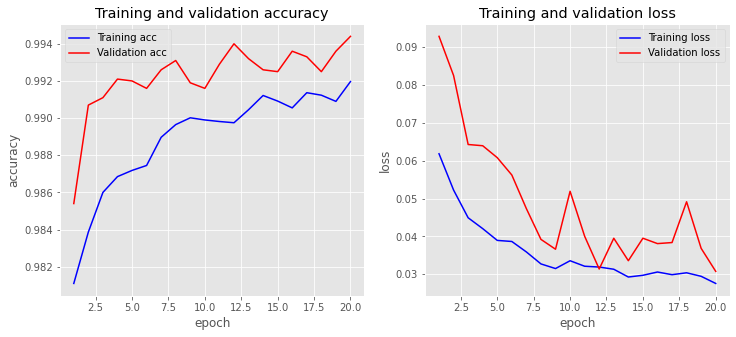

In [25]:
visual.plot_nn(history)

# evaluation at test dataset

In [26]:
# model accuracy on test dataset
score = model.evaluate([x_test, x_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=0)

In [28]:
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 99.4%


In [60]:
labels = [0,1,2,3,4,5,6,7,8,9]

10000/10000 [==============================] - 2s 154us/sample
comfusion matrix = 
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   1    1 1020    1    0    0    0    6    2    1]
 [   0    0    0 1007    0    2    0    0    1    0]
 [   0    0    0    0  980    0    0    0    0    2]
 [   1    0    0    3    0  886    1    0    0    1]
 [   3    6    0    0    0    0  947    0    2    0]
 [   0    3    2    0    0    0    0 1023    0    0]
 [   1    0    0    0    1    1    0    0  970    1]
 [   0    1    0    0    4    3    0    2    1  998]]

accuracy_score =  0.9944
balanced_accuracy_score =  0.9944

precision score =  0.9944
recall score =  0.9944
fp= [ 6. 11.  3.  5.  5.  6.  1.  8.  6.  5.]
fn= [ 0.  2. 12.  3.  2.  6. 11.  5.  4. 11.]
tp= [ 980. 1133. 1020. 1007.  980.  886.  947. 1023.  970.  998.]
tn= [9014. 8854. 8965. 8985. 9013. 9102. 9041. 8964. 9020. 8986.]

F1 score =  0.9944
F2 score =  [0.9951 0.9919 0.995

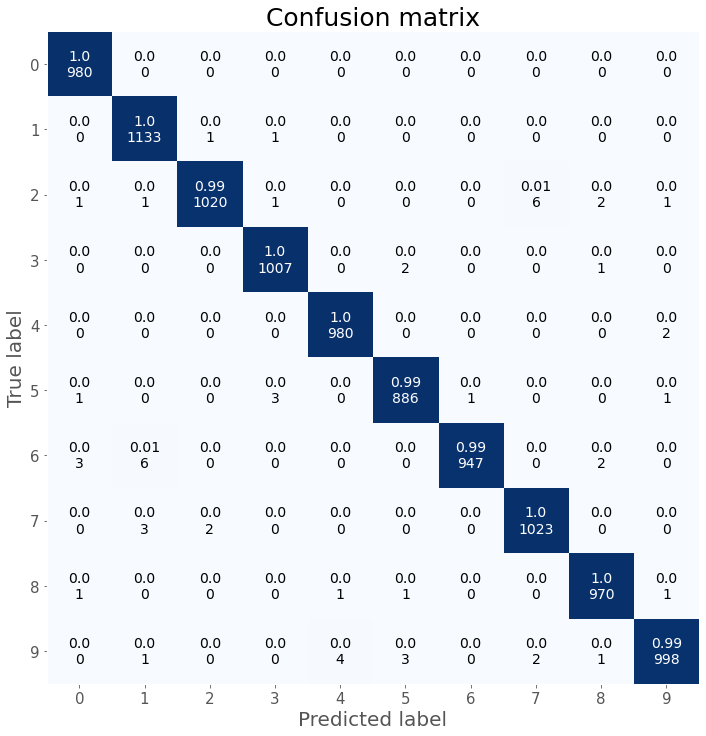


time span=  0:00:01.565998


In [64]:
y_test,yhat_classes_conv,yhat_probs = deep_learning.predict_model(model,[x_test, x_test],y_test,'multi','ovo',labels)